This notebook's goal is to perform sequence classification for the detection of abbreviations and long forms. We will be using a labeled dataset in the BIO (Begin, Inside, Outside) format.

* B-AC: Begin-Acronym
* B-LF: Begin-Long Form
* I-LF: Inside-Long Form
* B-O: Begin-Other

PLOD-CW dataset link <a href="https://huggingface.co/datasets/surrey-nlp/PLOD-CW" title="Huggingface">here</a>
<br>
In the PLOD-CW datasets "ner_tags" are stored as a seqence of strings.
Other 2 datasets will be used for this analysis and their "ner_tags" are already converted as integers.<br>

<br> 
In the code below you will find that some steps are repeated, for example dataset loading, data prepararion and function definition for alignment etc...<br> 

## Q1: Analyse and visualise the dataset

Before statting the analysis, here are some necessary libraries to have installed and to import.

In [ ]:
%pip install transformers==4.17
%pip install accelerate -U
%pip install seqeval
%pip install datasets
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install numpy
%pip install gensim
%pip install torch
%pip install ipython
%pip install tqdm
%pip install wandb
%pip install logging
%pip install optuna

In [ ]:
#Necessary imports
from datasets import load_dataset
import transformers
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer,
    DataCollatorForTokenClassification, RobertaTokenizer, RobertaModel, RobertaTokenizerFast,
    RobertaForTokenClassification, EarlyStoppingCallback
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import numpy as np
import wandb
import logging
import os
import gensim.downloader as api
from transformers import logging as hf_logging
import torch
import random
from IPython.display import display, HTML
%matplotlib inline
from datasets import load_metric, ClassLabel, Sequence
from seqeval.metrics import accuracy_score, f1_score
from seqeval.metrics import classification_report
from tqdm.notebook import tqdm
from transformers import AdamW, Trainer
from torch.optim import SGD
from transformers import Trainer, TrainingArguments, AdamW
import optuna

metric = load_metric("seqeval", trust_remote_code=True)

Suppress unwanted warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### First code for plotting some statistics for the PLOD-CW dataset

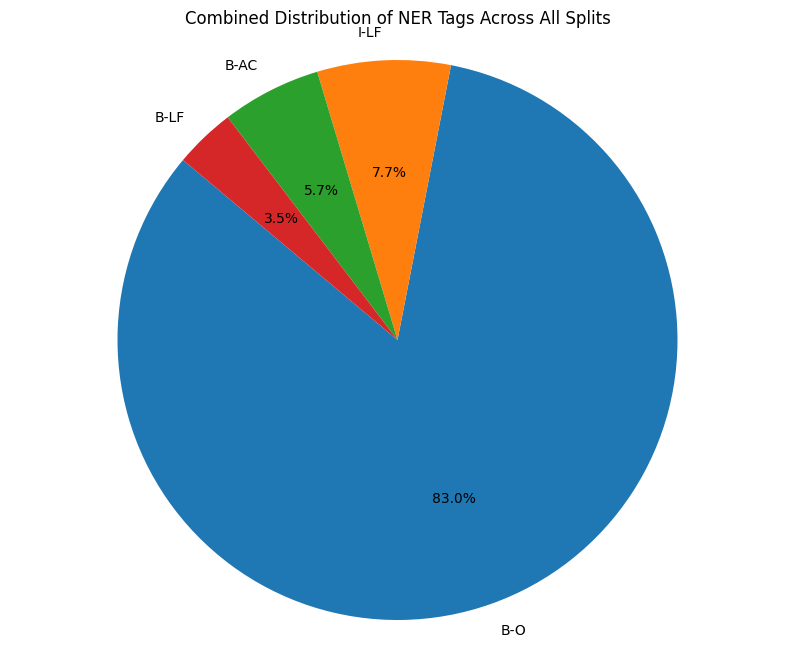

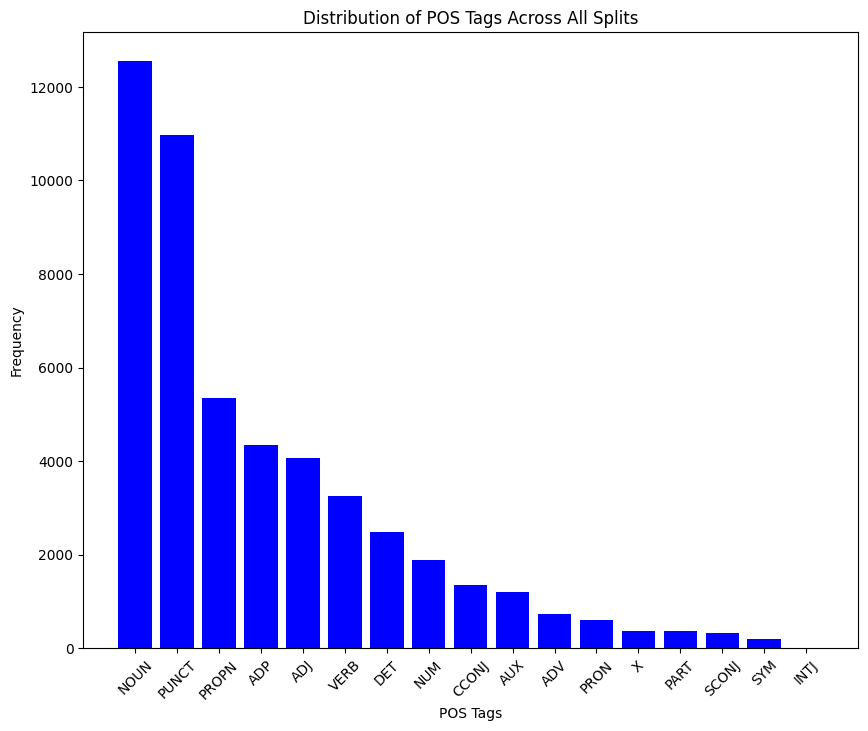

   POS_Tag  Train     Dev    Test    Total
0     NOUN   9999  1273.0  1271.0  12543.0
1    PUNCT   8886  1023.0  1066.0  10975.0
2    PROPN   4419   477.0   460.0   5356.0
3      ADP   3418   461.0   455.0   4334.0
4      ADJ   3195   418.0   442.0   4055.0
5     VERB   2596   342.0   316.0   3254.0
6      DET   1931   281.0   262.0   2474.0
7      NUM   1503   180.0   197.0   1880.0
8    CCONJ   1069   138.0   145.0   1352.0
9      AUX    938   118.0   139.0   1195.0
10     ADV    584    74.0    74.0    732.0
11    PRON    463    70.0    66.0    599.0
12       X    294    52.0    25.0    371.0
13    PART    292    32.0    34.0    358.0
14   SCONJ    255    35.0    27.0    317.0
15     SYM    157    26.0    21.0    204.0
16    INTJ      1     0.0     0.0      1.0


In [30]:
#Load the PLOD CW dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")

tokens_list = []
tags_list = []
pos_tags_list = []

def process_split(split):
    for example in dataset[split]:
        tokens_list.extend(example['tokens'])
        tags_list.extend(example['ner_tags'])
        pos_tags_list.extend(example['pos_tags'])

#using the function on all splits of the original PLOD CW dataset
splits = ['train', 'validation', 'test']
for split in splits:
    process_split(split)

ner_df = pd.DataFrame({'Token': tokens_list, 'NER_Tag': tags_list})
pos_df = pd.DataFrame({'Token': tokens_list, 'POS_Tag': pos_tags_list})
ner_tag_counts = ner_df['NER_Tag'].value_counts()
pos_tag_counts = pos_df['POS_Tag'].value_counts()

#Pie chart for ner tags
plt.figure(figsize=(10, 8))
plt.pie(ner_tag_counts, labels=ner_tag_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Combined Distribution of NER Tags Across All Splits')
plt.show()

#Histogram for pos tags
plt.figure(figsize=(10, 8))
plt.bar(pos_tag_counts.index, pos_tag_counts.values, color='blue')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('Distribution of POS Tags Across All Splits')
plt.xticks(rotation=45)
plt.show()

#Dataaframe
def count_pos_tags(split_data):
    pos_tags = [example['pos_tags'] for example in split_data]
    pos_tags_flat = [pos for sublist in pos_tags for pos in sublist]
    pos_tag_counts = pd.Series(pos_tags_flat).value_counts()
    return pos_tag_counts

train_pos_counts = count_pos_tags(dataset['train'])
dev_pos_counts = count_pos_tags(dataset['validation'])
test_pos_counts = count_pos_tags(dataset['test'])

pos_counts_df = pd.DataFrame({
    'Train': train_pos_counts,
    'Dev': dev_pos_counts,
    'Test': test_pos_counts
}).fillna(0)

pos_counts_df['Total'] = pos_counts_df.sum(axis=1)
pos_counts_df = pos_counts_df.sort_values(by='Total', ascending=False)
pos_counts_df.reset_index(inplace=True)
pos_counts_df.rename(columns={'index': 'POS_Tag'}, inplace=True)

print(pos_counts_df)

## Q2: Experimentation

### Experimental setup 1: 
* PLOD-CW dataset
* An SVM model with an RBF(Radial Basis Function) kernel.
* **<span style="color: lightgreen;">Variation: </span>** Vectorization method (TF-IDF, Word2Vec, Fasttext 1Gb, Fasttext 6Gb, GloVe)


 #### System 1.1 : SVM with TF-IDF

In [4]:
#SVM with TF-IDF encoding
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import load_dataset
import pandas as pd

#Dataset loading, this will be repeated many times trought the codes
datasets = load_dataset("surrey-nlp/PLOD-CW")

#Prepare the data for SVMmodel
def prepare_data(dataset):
    tokens = []
    labels = []
    for entry in dataset:
        tokens.extend(entry['tokens'])
        labels.extend(entry['ner_tags'])
    return tokens, labels

#Flattening the dataset
train_tokens, train_labels = prepare_data(datasets['train'])
test_tokens, test_labels = prepare_data(datasets['test'])

#using label encoder to encode the train and test labels
label_encoder = LabelEncoder()
train_labels_encoded1 = label_encoder.fit_transform(train_labels)
test_labels_encoded1 = label_encoder.transform(test_labels)

#feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_tokens)
X_test = vectorizer.transform(test_tokens)

#SVM model initialised with rbf kernel and balanced class weight, also fixed random state
svm_model = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)
svm_model.fit(X_train, train_labels_encoded1)

#I assigned a number to the prediction variable in order to store them
predictions1 = svm_model.predict(X_test)
#Unique variable names to store them and display the metrics afterwards
SVM_TFIDF_test_labels = label_encoder.inverse_transform(test_labels_encoded1)
SVM_TFIDF_predicted_labels = label_encoder.inverse_transform(predictions1)


#### System 1.2 : SVM with Word2Vec

In [5]:
#pre-trained Word2Vec model from gensim
wv = api.load('word2vec-google-news-300')

def get_word2vec_embeddings(dataset):
    features, labels = [], []
    for entry in dataset:
        for token, label in zip(entry['tokens'], entry['ner_tags']):
            if token in wv:
                features.append(wv[token])
                labels.append(label)
    return np.array(features), np.array(labels)

train_features, train_labels = get_word2vec_embeddings(datasets['train'])
test_features, test_labels = get_word2vec_embeddings(datasets['test'])

train_labels_encoded2 = label_encoder.fit_transform(train_labels)
test_labels_encoded2 = label_encoder.transform(test_labels)

svm_model.fit(train_features, train_labels_encoded2)
predictions2 = svm_model.predict(test_features)

SVM_Word2Vec_predicted_labels = label_encoder.inverse_transform(predictions2)
SVM_Word2Vec_test_labels = label_encoder.inverse_transform(test_labels_encoded2)

#### System 1.3 : SVM with Fasttext (1 Gb)

In [6]:
from gensim.models import FastText
wv = api.load('fasttext-wiki-news-subwords-300')

def get_word2vec_embeddings(dataset):
    features = []
    labels = []
    for entry in dataset:
        for token, label in zip(entry['tokens'], entry['ner_tags']):
            if token in wv:
                features.append(wv[token])
                labels.append(label)

    return np.array(features), np.array(labels)

train_features, train_labels = get_word2vec_embeddings(datasets['train'])
test_features, test_labels = get_word2vec_embeddings(datasets['test'])

label_encoder = LabelEncoder()
train_labels_encoded3 = label_encoder.fit_transform(train_labels)
test_labels_encoded3 = label_encoder.transform(test_labels)

svm_model.fit(train_features, train_labels_encoded3)
predictions3 = svm_model.predict(test_features)

SVM_Fasttext_predicted_labels = label_encoder.inverse_transform(predictions3)
SVM_Fasttext_test_labels = label_encoder.inverse_transform(test_labels_encoded3)

#### System 1.4 : Fasttext 2 (6 Gb)

In [7]:
from torchtext import vocab
MAX_VOCAB_SIZE = 25_000
fasttext_vectors = vocab.FastText(language='en', max_vectors=MAX_VOCAB_SIZE)
fasttext_vocab = {word: i for i, word in enumerate(fasttext_vectors.itos)}

def get_fasttext_embeddings(dataset):
    features = []
    labels = []
    for entry in dataset:
        for token, label in zip(entry['tokens'], entry['ner_tags']):
            idx = fasttext_vocab.get(token.lower(), 0)  # Fallback to '<unk>' vector at index 0
            features.append(fasttext_vectors.vectors[idx].numpy())
            labels.append(label)

    return np.array(features), np.array(labels)

train_features, train_labels = get_fasttext_embeddings(datasets['train'])
test_features, test_labels = get_fasttext_embeddings(datasets['test'])

label_encoder = LabelEncoder()
train_labels_encoded4 = label_encoder.fit_transform(train_labels)
test_labels_encoded4 = label_encoder.transform(test_labels)

svm_model.fit(train_features, train_labels_encoded4)
predictions4 = svm_model.predict(test_features)
SVM_Fasttext2_predicted_labels = label_encoder.inverse_transform(predictions4)
SVM_Fasttext2_test_labels = label_encoder.inverse_transform(test_labels_encoded4)

#### System 1.5 : SVM with GloVe  https://nlp.stanford.edu/projects/glove/

In [8]:
MAX_VOCAB_SIZE = 25_000
glove_vectors = vocab.GloVe(name="6B", dim=100, max_vectors=MAX_VOCAB_SIZE)
glove_vocab = {word: i for i, word in enumerate(glove_vectors.itos)}

def get_glove_embeddings(dataset):
    features = []
    labels = []
    for entry in dataset:
        for token, label in zip(entry['tokens'], entry['ner_tags']):
            # Use the embedding for the token if it exists, otherwise use a zero vector
            idx = glove_vocab.get(token.lower(), 0)  # Fallback to '<unk>' vector at index 0
            features.append(glove_vectors.vectors[idx].numpy())
            labels.append(label)

    return np.array(features), np.array(labels)

train_features, train_labels = get_glove_embeddings(datasets['train'])
test_features, test_labels = get_glove_embeddings(datasets['test'])

label_encoder = LabelEncoder()
train_labels_encoded5 = label_encoder.fit_transform(train_labels)
test_labels_encoded5 = label_encoder.transform(test_labels)

svm_model.fit(train_features, train_labels_encoded5)
predictions5 = svm_model.predict(test_features)

SVM_GloVe_predicted_labels = label_encoder.inverse_transform(predictions5)
SVM_GloVe_test_labels = label_encoder.inverse_transform(test_labels_encoded5)

### Experimental setup 2:

* PLOD-CW dataset
* distilBERT transformer
* **<span style="color: lightgreen;">Variation: </span>** Optimisation method (Adam, SGD, RMSprop)

#### System 2.1 : distilBERT with Adam

In [ ]:
datasets = load_dataset("surrey-nlp/PLOD-CW")

task = "ner"
model_checkpoint = "distilbert-base-uncased"
pretrained_model = "distilbert-base-uncased"
batch_size = 32
model_name = "distilbert-base-uncased"

label_list = ['B-O', 'B-AC', 'B-LF', 'I-LF']

#transform textlabels in numbers and appends them to the dataset in a column
tag_to_id = {tag: i for i, tag in enumerate(label_list)}
for dataset in datasets:
    ner_tags = [[tag_to_id[tag] for tag in ner_tag] for ner_tag in datasets[dataset]['ner_tags']]
    datasets[dataset] = datasets[dataset].add_column('ner_tags_id', ner_tags)


from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', padding=True, truncation=True, max_length=512)
assert isinstance(tokenizer, DistilBertTokenizerFast)

#some examples (code from the lab 7)
example = datasets["train"][3]

tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(" The two values should match: ", len(aligned_labels), len(tokenized_input["input_ids"]))
label_all_tokens = True

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], 
        truncation=True, 
        padding="max_length",
        max_length=512, #this could also be changed to the value proposed in the PLOD-CW CW sheet
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples[f"{task}_tags_id"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

label_all_tokens = True
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

model = AutoModelForTokenClassification.from_pretrained(pretrained_model, num_labels=len(label_list))

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    report_to="wandb",
    evaluation_strategy ='epoch',
    logging_strategy='epoch',
    eval_steps = 7000,
    logging_steps=20,
    save_total_limit = 10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=10,
    num_train_epochs=6,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=False
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval", trust_remote_code=True)

labels = [label_list[i] for i in example[f"{task}_tags_id"]]

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

#Optimiser choice
optimizer = AdamW(model.parameters(), lr=5e-5)

#Passing the optimizer to the trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None)
)

trainer.train()
trainer.evaluate()

predictions6, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions6 = np.argmax(predictions6, axis=2)

ADAM_true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions6, labels)
]
ADAM_true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions6, labels)
]

trainer.save_model('distilBERT-uncased-ADAM')

ADAM_true_labels_flat = [item for sublist in ADAM_true_labels for item in sublist]
ADAM_true_predictions_flat = [item for sublist in ADAM_true_predictions for item in sublist]

#### System 2.2 distilBERT with SGD

In [53]:
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    report_to="wandb",
    evaluation_strategy ='epoch',
    logging_strategy='epoch',
    eval_steps = 7000,
    logging_steps=20,
    save_total_limit = 10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=10,
    num_train_epochs=6,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=False
)

PyTorch: setting up devices


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None)
)
trainer.train()

trainer.evaluate()

predictions7, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions7 = np.argmax(predictions7, axis=2)

SGD_true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions7, labels)
]
SGD_true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions7, labels)
]

trainer.save_model('distilBERT-uncased-SGD')

SGD_true_labels_flat = [item for sublist in SGD_true_labels for item in sublist]
SGD_true_predictions_flat = [item for sublist in SGD_true_predictions for item in sublist]


#### System 2.3 RMSprop

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=2e-5, alpha=0.99, eps=1e-8, weight_decay=0.001, momentum=0.9)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None)
)

trainer.train()
trainer.evaluate()

predictions8, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions8 = np.argmax(predictions8, axis=2)

RMS_true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions8, labels)
]
RMS_true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions8, labels)
]

trainer.save_model('distilBERT-uncased-RMS')

RMS_true_labels_flat = [item for sublist in RMS_true_labels for item in sublist]
RMS_true_predictions_flat = [item for sublist in RMS_true_predictions for item in sublist]


### Experimental setup 3:
* PLOD-CW dataset
* roBERTa-base transformer
* **<span style="color: lightgreen;">Variation: </span>** Finetuning method (Optuna TPE, Random search, Grid Search)



#### System 3.1 : Tree-structured Parzen Estimator

In [ ]:
#wandb and hf_notebook login and setup to reduce console messages as they caused Jupyter notebook to crash
os.environ['WANDB_SILENT'] = 'true'
hf_logging.set_verbosity_error()

wandb.init(settings=wandb.Settings(console='off'))
wandb.login()
%env WANDB_LOG_MODEL=true
%env WANDB_WATCH=all

Optuna's optimisers are an adapted version of the code that can be found here by navigating trough the different samplers: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html 

In [ ]:
wandb.init(project="roBERTa-base-CW-optim", entity="maxnardone", settings=wandb.Settings(console='off'))

#All the steps are repeated just like the distilBERT model
datasets = load_dataset("surrey-nlp/PLOD-CW")

task = "ner"
model_checkpoint = "roberta-base"
pretrained_model = "roberta-base"
batch_size = 32
model_name = "roberta-base"

label_list = ['B-O', 'B-AC', 'I-AC', 'B-LF', 'I-LF']

tag_to_id = {tag: i for i, tag in enumerate(label_list)}

for dataset in datasets:
    converted_tags = []
    ner_tags = []
    for i, ner_tag in enumerate(datasets[dataset]['ner_tags']):
        tag_ids = [tag_to_id[tag] for tag in ner_tag]
        ner_tags.append(tag_ids)

    datasets[dataset] = datasets[dataset].add_column('ner_tags_id', ner_tags)

tokenizer = AutoTokenizer.from_pretrained(pretrained_model, add_prefix_space=True)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

example = datasets["train"][4]

tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(" The two values should match: ", len(aligned_labels), len(tokenized_input["input_ids"]))
label_all_tokens = True

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags_id"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

def model_init():
    return AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [[label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}

trainer = Trainer(
    model_init=model_init,
    args=TrainingArguments(
        output_dir=f"{model_checkpoint}-finetuned-{task}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        report_to="wandb",
        load_best_model_at_end=True,
        fp16=True
    ),
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#Hyperparameter space to search
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_loguniform("learning_rate", 2e-6, 2e-4),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "adam_beta1": trial.suggest_float("adam_beta1", 0.8, 0.95)
    }

best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=8)

#Print of the best results
print("Best trial:", best_run.objective)
print("Best trial parameters:", best_run.hyperparameters)


#Re-initialise trainer and arguments
training_args = TrainingArguments(
    output_dir=f"{model_checkpoint}-finetuned-{task}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=best_run.hyperparameters['per_device_train_batch_size'],
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    learning_rate=best_run.hyperparameters['learning_rate'],
    adam_beta1=best_run.hyperparameters['adam_beta1'],
    report_to="wandb",
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

predictions9, labels, _ = trainer.predict(tokenized_datasets["test"])
wandb.finish()
rob1_true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions9.argmax(axis=2), labels)
]

rob1_true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions9.argmax(axis=2), labels)
]


 #### System 3.2 Random search

In [ ]:
wandb.init(project="roBERTa-base-CW-optim", entity="maxnardone")

def create_training_args(trial_params=None):
    if trial_params is None:
        trial_params = {
            "learning_rate": 2e-5,
            "per_device_train_batch_size": 8,
            "adam_beta1": 0.9
        }
    return TrainingArguments(
        output_dir='./results',
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=trial_params["learning_rate"],
        per_device_train_batch_size=trial_params["per_device_train_batch_size"],
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        report_to="wandb",
        load_best_model_at_end=True,
        fp16=True
    )

def objective(trial):
    trial_params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 2e-6, 2e-4),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "adam_beta1": trial.suggest_float("adam_beta1", 0.8, 0.95)
    }
    training_args = create_training_args(trial_params)
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=DataCollatorForTokenClassification(tokenizer),
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result["eval_loss"]

study = optuna.create_study(sampler=optuna.samplers.RandomSampler(), direction="minimize")
study.optimize(objective, n_trials=8)

best_trial = study.best_trial
print("Best trial scores:", best_trial.value)
print("Best trial parameters:", best_trial.params)

training_args = create_training_args(best_trial.params)
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
wandb.finish()

predictions10, labels, _ = trainer.predict(tokenized_datasets["test"])
rob2_true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions10.argmax(axis=2), labels)
]

rob2_true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions10.argmax(axis=2), labels)
]



 #### System 3.3 Gridsearch

In [ ]:
wandb.init(project="roBERTa-base-CW-optim", entity="maxnardone")

def create_training_args(trial_params=None):
    if trial_params is None:
        trial_params = {
            "learning_rate": 2e-5,
            "per_device_train_batch_size": 8,
            "adam_beta1": 0.9
        }
    return TrainingArguments(
        output_dir='./results',
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=trial_params["learning_rate"],
        per_device_train_batch_size=trial_params["per_device_train_batch_size"],
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        report_to="wandb",
        load_best_model_at_end=True,
        fp16=True
    )

def objective(trial):
    trial_params = {
        "learning_rate": trial.suggest_categorical("learning_rate", [2e-6, 2e-4]),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "adam_beta1": trial.suggest_categorical("adam_beta1", [0.8, 0.95])
    }
    training_args = create_training_args(trial_params)
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=DataCollatorForTokenClassification(tokenizer),
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result["eval_loss"]

#I found that defining a search space again works best even if it duplicates the code
search_space = {
    "learning_rate": [2e-6, 2e-4],
    "per_device_train_batch_size": [8, 16],
    "adam_beta1": [0.8, 0.95]
}

study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space), direction="minimize")
study.optimize(objective, n_trials=8)

best_trial = study.best_trial
print("Best trial scores:", best_trial.value)
print("Best trial parameters:", best_trial.params)

training_args = create_training_args(best_trial.params)
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
wandb.finish()

predictions11, labels, _ = trainer.predict(tokenized_datasets["test"])
rob3_true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions11.argmax(axis=2), labels)
]

rob3_true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions11.argmax(axis=2), labels)
]

### Experimental setup 4:

* distilBERT transformer
* **<span style="color: lightgreen;">Variation: </span>** Dataset (PLOD-CW, PLOD-filtered, PLOD-unfiltered)

#### System 4.1 : DistilBERT using PLOD-CW dataset

In [ ]:
wandb.init(project="distilBERT-uncased-CW", entity="maxnardone")

datasets = load_dataset("surrey-nlp/PLOD-CW")

task = "ner"
model_checkpoint = "distilbert-base-uncased"
pretrained_model = "distilbert-base-uncased"
batch_size = 32
model_name = "distilbert-base-uncased"

label_list = ['B-O', 'B-AC', 'B-LF', 'I-LF']

tag_to_id = {tag: i for i, tag in enumerate(label_list)}

for dataset in datasets:
    ner_tags = [[tag_to_id[tag] for tag in ner_tag] for ner_tag in datasets[dataset]['ner_tags']]
    datasets[dataset] = datasets[dataset].add_column('ner_tags_id', ner_tags)


from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', padding=True, truncation=True, max_length=512)
assert isinstance(tokenizer, DistilBertTokenizerFast)

example = datasets["train"][4]

tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(" The two values should match: ", len(aligned_labels), len(tokenized_input["input_ids"]))
label_all_tokens = True


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags_id"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

label_all_tokens = True
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

model = AutoModelForTokenClassification.from_pretrained(pretrained_model, num_labels=len(label_list))

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    report_to="wandb",
    evaluation_strategy ='epoch',
    logging_strategy='epoch',
    eval_steps = 7000,
    logging_steps=20,
    save_total_limit = 10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=10,
    num_train_epochs=5,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=False
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval", trust_remote_code=True)

labels = [label_list[i] for i in example[f"{task}_tags_id"]]

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

predictions12, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions12 = np.argmax(predictions12, axis=2)

Distil_CW_true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions12, labels)
]
Distil_CW_true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions12, labels)
]

results = metric.compute(predictions=Distil_CW_true_predictions, references=Distil_CW_true_labels)
print("\n ")
print(results)

trainer.save_model('CW-distilBERT-uncased-ner')
wandb.finish()

Distil_CW_true_labels_flat = [item for sublist in Distil_CW_true_labels for item in sublist]
Distil_CW_true_predictions_flat = [item for sublist in Distil_CW_true_predictions for item in sublist]

#### System 4.2 Distillbert with PLOD-filtered

In [ ]:
wandb.init(project="distilBERT-filtered", entity="maxnardone")

datasets = load_dataset("surrey-nlp/PLOD-filtered")
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', padding=True, truncation=True, max_length=512)

label_list = ['B-O', 'B-AC', 'I-AC', 'B-LF', 'I-LF']
#I-LF class added to check istances of this new one

#The ner_tags are in integer form
for dataset in datasets:
    datasets[dataset] = datasets[dataset].add_column('ner_tags_id', datasets[dataset]['ner_tags'])

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags_id"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

label_all_tokens = True
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

pretrained_model = "distilbert-base-uncased"
model = AutoModelForTokenClassification.from_pretrained(pretrained_model, num_labels=len(label_list))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

trainer.save_model('filtered-distilBERT-uncased')

predictions13, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions13 = np.argmax(predictions13, axis=2)

In [30]:
if not wandb.run:
    wandb.init(project="distilBERT-filtered", entity="maxnardone", resume="allow")

In [31]:
#Code to resume the evaluation since i closed wandb
try:
    predictions13, labels, _ = trainer.predict(tokenized_datasets["test"])
    predictions13 = np.argmax(predictions13, axis=2)
except AttributeError as e:
    print(f"Error during prediction with wandb: {e}")
    wandb.init(project="distilBERT-filtered", entity="maxnardone", resume="allow")
    predictions13, labels, _ = trainer.predict(tokenized_datasets["test"])
    predictions13 = np.argmax(predictions13, axis=2)

The following columns in the test set  don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: pos_tags, id, ner_tags_id, tokens, ner_tags. If pos_tags, id, ner_tags_id, tokens, ner_tags are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 24140
  Batch size = 10


In [ ]:
wandb.finish()
Distil_F_true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions13, labels)
]
Distil_F_true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions13, labels)
]

Distil_F_true_labels_flat = [item for sublist in Distil_F_true_labels for item in sublist]
Distil_F_true_predictions_flat = [item for sublist in Distil_F_true_predictions for item in sublist]

#### System 4.3

In [ ]:
wandb.init(project="distilBERT-unfiltered", entity="maxnardone")

datasets = load_dataset("surrey-nlp/PLOD-unfiltered")
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', padding=True, truncation=True, max_length=512)

label_list = ['B-O', 'B-AC', 'I-AC', 'B-LF', 'I-LF']

for dataset in datasets:
    datasets[dataset] = datasets[dataset].add_column('ner_tags_id', datasets[dataset]['ner_tags'])

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags_id"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

label_all_tokens = True
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

pretrained_model = "distilbert-base-uncased"
model = AutoModelForTokenClassification.from_pretrained(pretrained_model, num_labels=len(label_list))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

trainer.save_model('unfiltered-distilBERT-uncased')

predictions14, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions14 = np.argmax(predictions14, axis=2)

wandb.finish()

Distil_Unf_true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions14, labels)
]
Distil_Unf_true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions14, labels)
]

Distil_Unf_true_labels_flat = [item for sublist in Distil_Unf_true_labels for item in sublist]
Distil_Unf_true_predictions_flat = [item for sublist in Distil_Unf_true_predictions for item in sublist]

## Q3 - Analysis

### Confusion matrix code

In [3]:
#Confusion matrix plot, from prof. Diptesh Kanojia's code (See before Section 1 for reference)
def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [4]:
#Import again here to make sure we are using Seqeval's classification report and not Sklearn one
from seqeval.metrics import classification_report

### Experiment 1

Code to convert back labels to usel seqeval 

In [11]:
label_list = ['B-O', 'B-AC', 'B-LF', 'I-LF']
label_encoder = LabelEncoder()
label_encoder.fit(label_list)

#convert back
def labels_to_seqeval_format(encoded_labels, label_encoder):
    return [[label_encoder.inverse_transform([label])[0]] for label in encoded_labels]

#### Results for 1.1

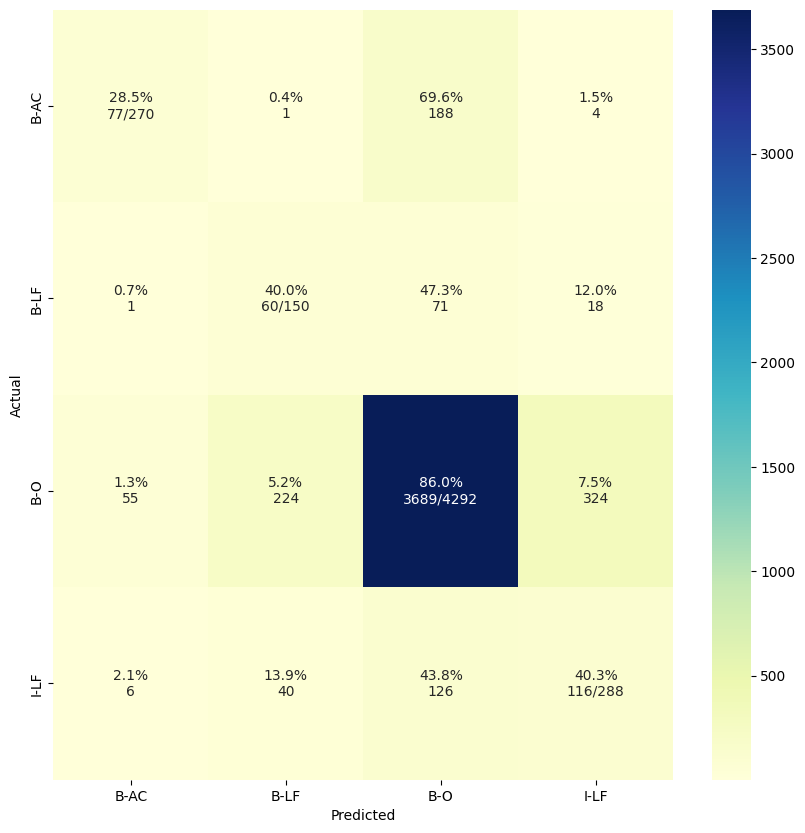

In [12]:
plot_cm(SVM_TFIDF_test_labels, SVM_TFIDF_predicted_labels)

In [13]:
SVM_TFIDF_test_labels_seqeval = labels_to_seqeval_format(test_labels_encoded1, label_encoder)
SVM_TFIDF_predicted_labels_seqeval = labels_to_seqeval_format(predictions1, label_encoder)

print(classification_report(SVM_TFIDF_test_labels_seqeval, SVM_TFIDF_predicted_labels_seqeval))

              precision    recall  f1-score   support

          AC       0.34      0.36      0.35       558
          LF       0.18      0.40      0.25       150
           O       0.91      0.86      0.88      4292

   micro avg       0.79      0.79      0.79      5000
   macro avg       0.48      0.54      0.49      5000
weighted avg       0.82      0.79      0.80      5000



#### Results for 1.2

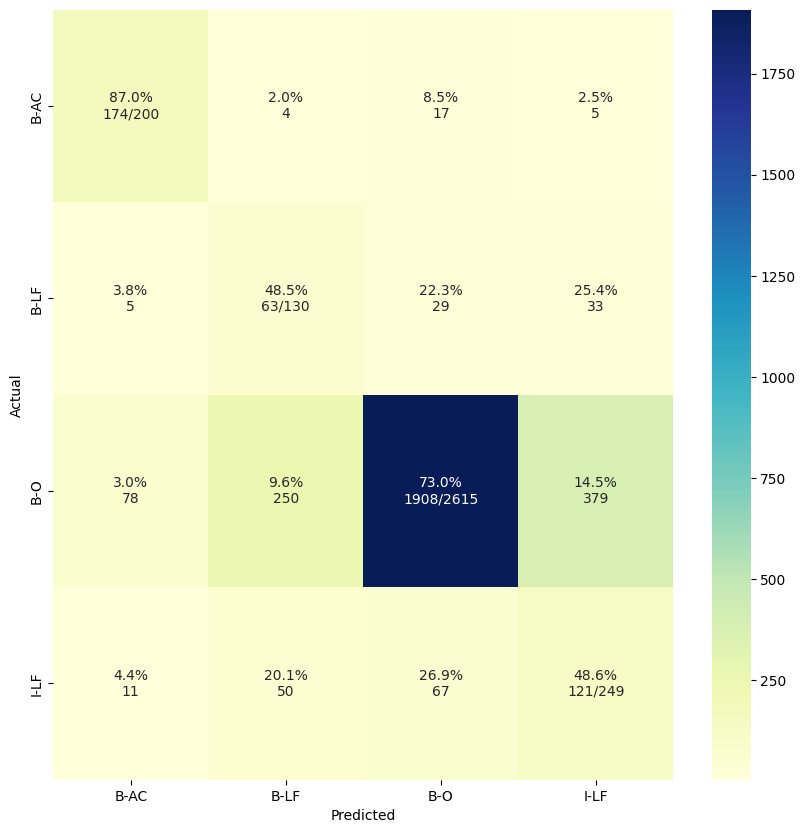

In [14]:
plot_cm(SVM_Word2Vec_test_labels, SVM_Word2Vec_predicted_labels)

In [15]:
SVM_Word2Vec_test_labels_seqeval = labels_to_seqeval_format(test_labels_encoded2, label_encoder)
SVM_Word2Vec_predicted_labels_seqeval = labels_to_seqeval_format(predictions2, label_encoder)

print(classification_report(SVM_Word2Vec_test_labels_seqeval, SVM_Word2Vec_predicted_labels_seqeval))

              precision    recall  f1-score   support

          AC       0.39      0.69      0.50       449
          LF       0.17      0.48      0.25       130
           O       0.94      0.73      0.82      2615

   micro avg       0.71      0.71      0.71      3194
   macro avg       0.50      0.64      0.52      3194
weighted avg       0.83      0.71      0.75      3194



#### Results for 1.3

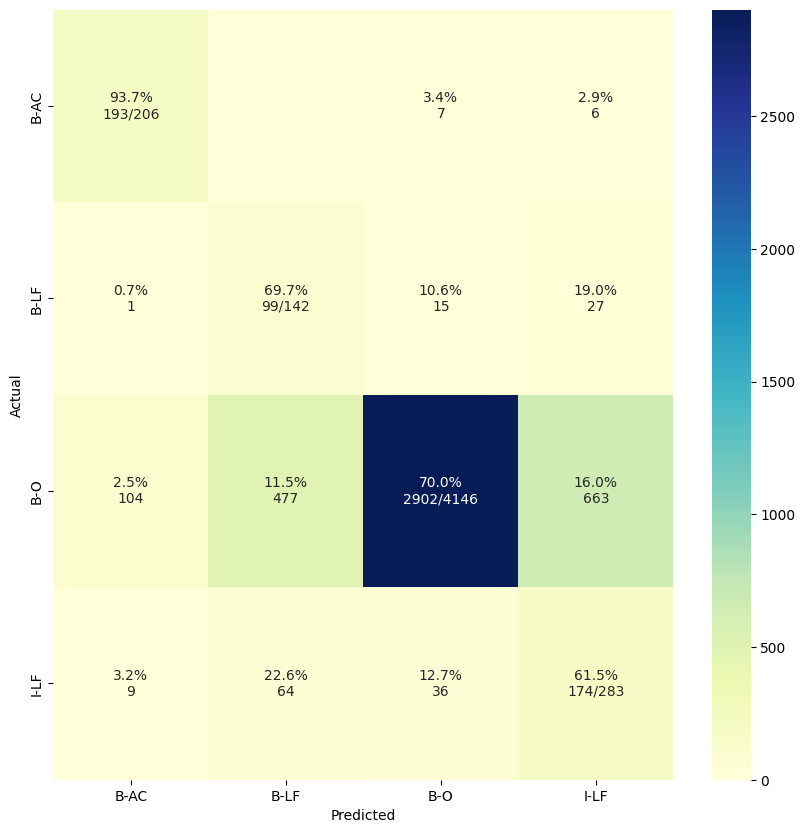

In [16]:
plot_cm(SVM_Fasttext_test_labels, SVM_Fasttext_predicted_labels)

In [17]:
SVM_Fasttext_test_labels_seqeval = labels_to_seqeval_format(test_labels_encoded3, label_encoder)
SVM_Fasttext_predicted_labels_seqeval = labels_to_seqeval_format(predictions3, label_encoder)

print(classification_report(SVM_Fasttext_test_labels_seqeval, SVM_Fasttext_predicted_labels_seqeval))

              precision    recall  f1-score   support

          AC       0.32      0.78      0.46       489
          LF       0.15      0.70      0.25       142
           O       0.98      0.70      0.82      4146

   micro avg       0.71      0.71      0.71      4777
   macro avg       0.49      0.73      0.51      4777
weighted avg       0.89      0.71      0.76      4777



#### Results for 1.4

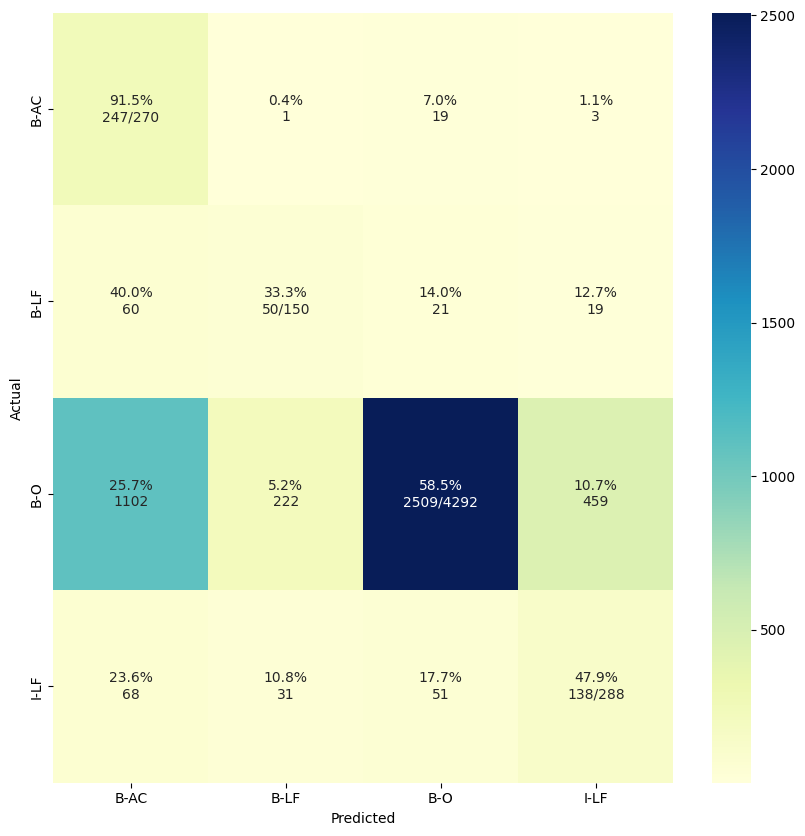

In [18]:
plot_cm(SVM_Fasttext2_test_labels, SVM_Fasttext2_predicted_labels)

In [19]:
SVM_Fasttext2_test_labels_seqeval = labels_to_seqeval_format(test_labels_encoded4, label_encoder)
SVM_Fasttext2_predicted_labels_seqeval = labels_to_seqeval_format(predictions4, label_encoder)

print(classification_report(SVM_Fasttext2_test_labels_seqeval, SVM_Fasttext2_predicted_labels_seqeval))

              precision    recall  f1-score   support

          AC       0.22      0.82      0.34       558
          LF       0.16      0.33      0.22       150
           O       0.96      0.58      0.73      4292

   micro avg       0.60      0.60      0.60      5000
   macro avg       0.45      0.58      0.43      5000
weighted avg       0.86      0.60      0.67      5000



#### Results for 1.5

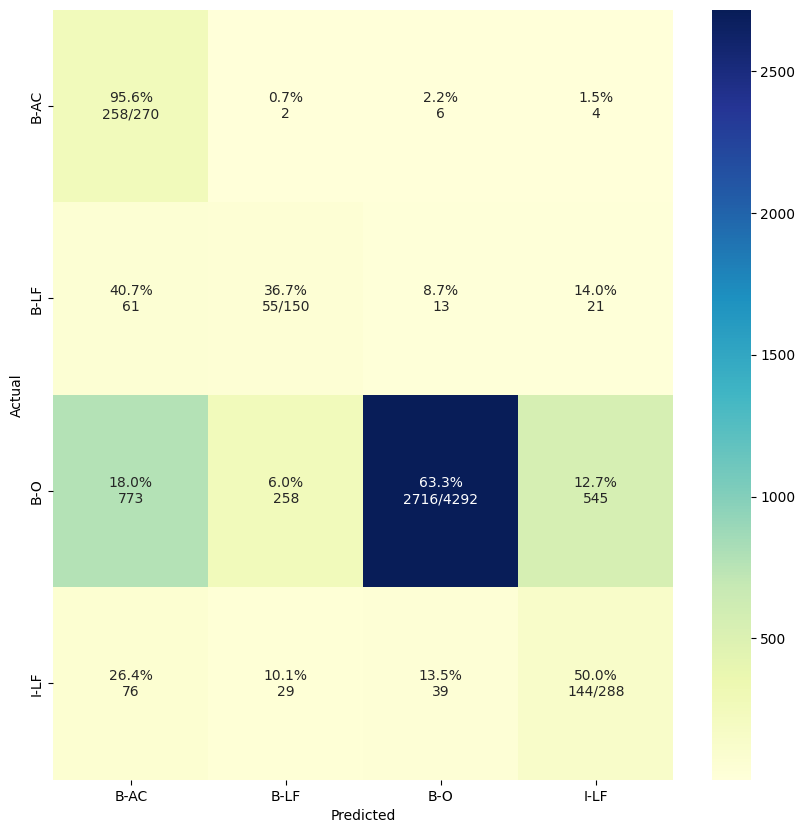

In [20]:
plot_cm(SVM_GloVe_test_labels, SVM_GloVe_predicted_labels)

In [21]:
SVM_GloVe_test_labels_seqeval = labels_to_seqeval_format(test_labels_encoded5, label_encoder)
SVM_GloVe_predicted_labels_seqeval = labels_to_seqeval_format(predictions5, label_encoder)

print(classification_report(SVM_GloVe_test_labels_seqeval, SVM_GloVe_predicted_labels_seqeval))

              precision    recall  f1-score   support

          AC       0.26      0.86      0.40       558
          LF       0.16      0.37      0.22       150
           O       0.98      0.63      0.77      4292

   micro avg       0.65      0.65      0.65      5000
   macro avg       0.47      0.62      0.46      5000
weighted avg       0.87      0.65      0.71      5000



#### Overall Comparison for Experiment 1

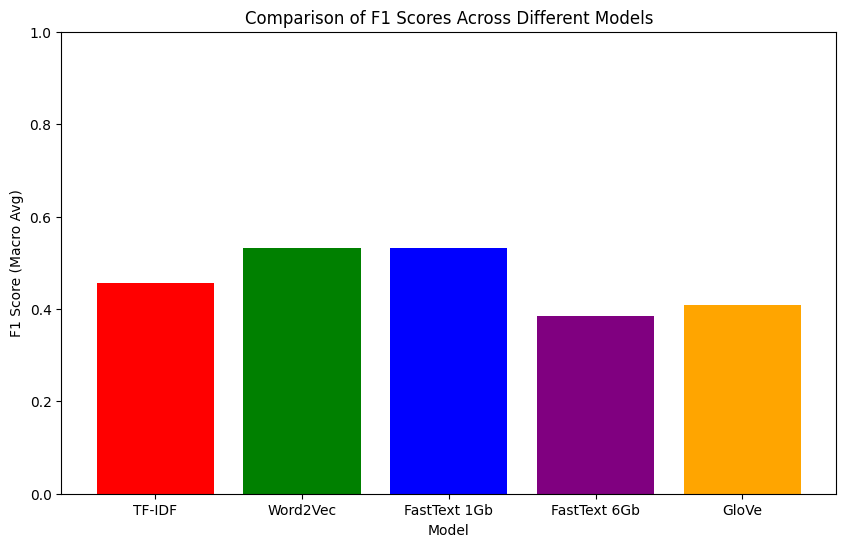

In [39]:
reports = [
    classification_report(SVM_TFIDF_test_labels, SVM_TFIDF_predicted_labels, output_dict=True),
    classification_report(SVM_Word2Vec_test_labels, SVM_Word2Vec_predicted_labels, output_dict=True),
    classification_report(SVM_Fasttext_test_labels, SVM_Fasttext_predicted_labels, output_dict=True),
    classification_report(SVM_Fasttext2_test_labels, SVM_Fasttext2_predicted_labels, output_dict=True),
    classification_report(SVM_GloVe_test_labels, SVM_GloVe_predicted_labels, output_dict=True)
]

f1_scores = [report['macro avg']['f1-score'] for report in reports]
model_names = ['TF-IDF', 'Word2Vec', 'FastText 1Gb', 'FastText 6Gb', 'GloVe']

plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('F1 Score (Macro Avg)')
plt.title('Comparison of F1 Scores Across Different Models')
plt.ylim([0, 1])
plt.show()

### Experiment 2

#### Results for 2.1

In [ ]:
plot_cm(ADAM_true_labels_flat, ADAM_true_predictions_flat)

results_ADAM = metric.compute(predictions=ADAM_true_predictions, references=ADAM_true_labels)
print(results_ADAM)

print(classification_report(ADAM_true_labels, ADAM_true_predictions, digits=2))

#### Results for 2.2

{'AC': {'precision': 0.7486725663716814, 'recall': 0.773308957952468, 'f1': 0.7607913669064749, 'number': 547}, 'LF': {'precision': 0.7051671732522796, 'recall': 0.7682119205298014, 'f1': 0.7353407290015848, 'number': 302}, 'O': {'precision': 0.9644394534905484, 'recall': 0.9547896979803595, 'f1': 0.9595903165735568, 'number': 5397}, 'overall_precision': 0.9312169312169312, 'overall_recall': 0.9298751200768491, 'overall_f1': 0.9305455419370343, 'overall_accuracy': 0.9269282814614344}
              precision    recall  f1-score   support

          AC       0.75      0.77      0.76       547
          LF       0.71      0.77      0.74       302
           O       0.96      0.95      0.96      5397

   micro avg       0.93      0.93      0.93      6246
   macro avg       0.81      0.83      0.82      6246
weighted avg       0.93      0.93      0.93      6246



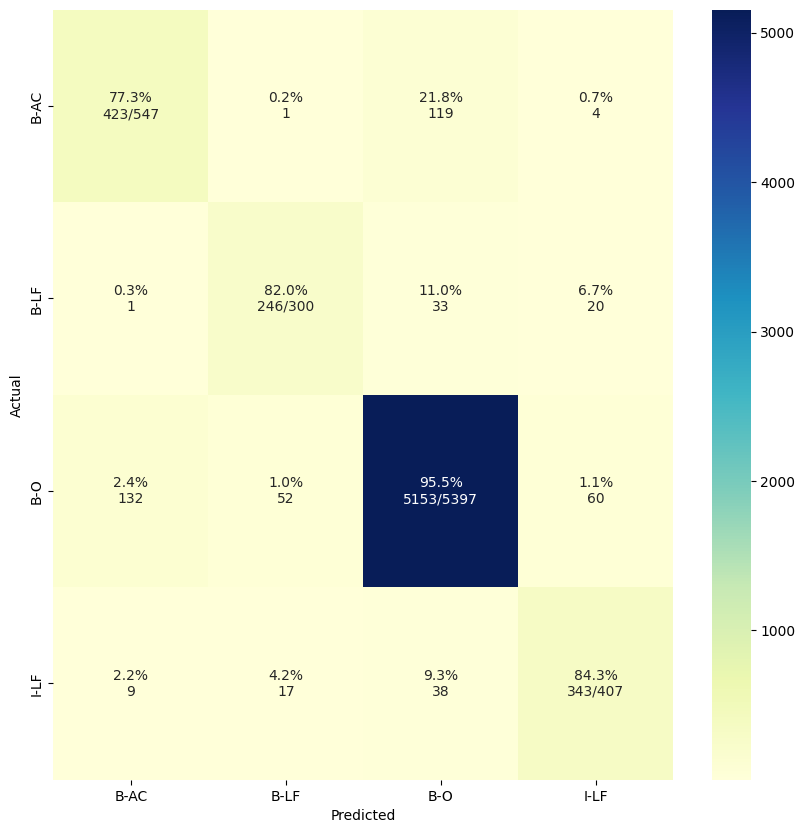

In [72]:
plot_cm(SGD_true_labels_flat, SGD_true_predictions_flat)

results_SGD = metric.compute(predictions=SGD_true_predictions, references=SGD_true_labels)
print(results_SGD)

print(classification_report(SGD_true_labels, SGD_true_predictions, digits=2))

#### results for 2.3

{'AC': {'precision': 0.7380530973451327, 'recall': 0.7623400365630713, 'f1': 0.7499999999999999, 'number': 547}, 'LF': {'precision': 0.7284768211920529, 'recall': 0.7284768211920529, 'f1': 0.7284768211920529, 'number': 302}, 'O': {'precision': 0.9577359895736361, 'recall': 0.9531221048730776, 'f1': 0.9554234769687964, 'number': 5397}, 'overall_precision': 0.9267393395319012, 'overall_recall': 0.925552353506244, 'overall_f1': 0.9261454661967318, 'overall_accuracy': 0.9209141482483837}
              precision    recall  f1-score   support

          AC       0.74      0.76      0.75       547
          LF       0.73      0.73      0.73       302
           O       0.96      0.95      0.96      5397

   micro avg       0.93      0.93      0.93      6246
   macro avg       0.81      0.81      0.81      6246
weighted avg       0.93      0.93      0.93      6246



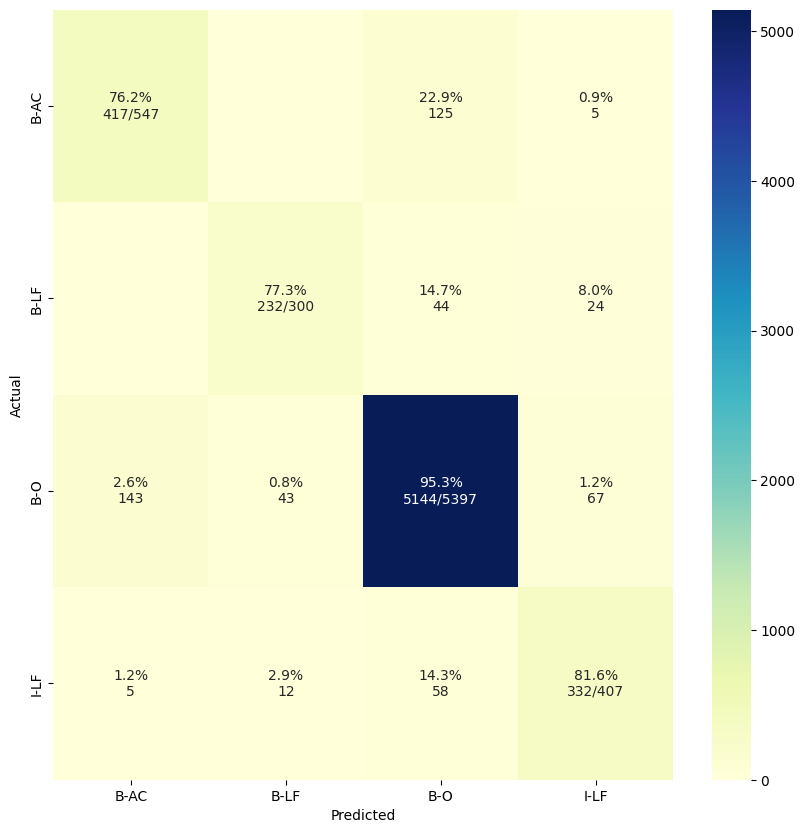

In [60]:
plot_cm(RMS_true_labels_flat, RMS_true_predictions_flat)

results_RMS = metric.compute(predictions=RMS_true_predictions, references=RMS_true_labels)
print(results_RMS)

print(classification_report(RMS_true_labels, RMS_true_predictions, digits=2))

### Experiment 3

#### Results for 3.1

              precision    recall  f1-score   support

          AC       0.82      0.80      0.81       559
          LF       0.69      0.83      0.75       290
           O       0.97      0.95      0.96      5274

   micro avg       0.94      0.93      0.94      6123
   macro avg       0.83      0.86      0.84      6123
weighted avg       0.94      0.93      0.94      6123



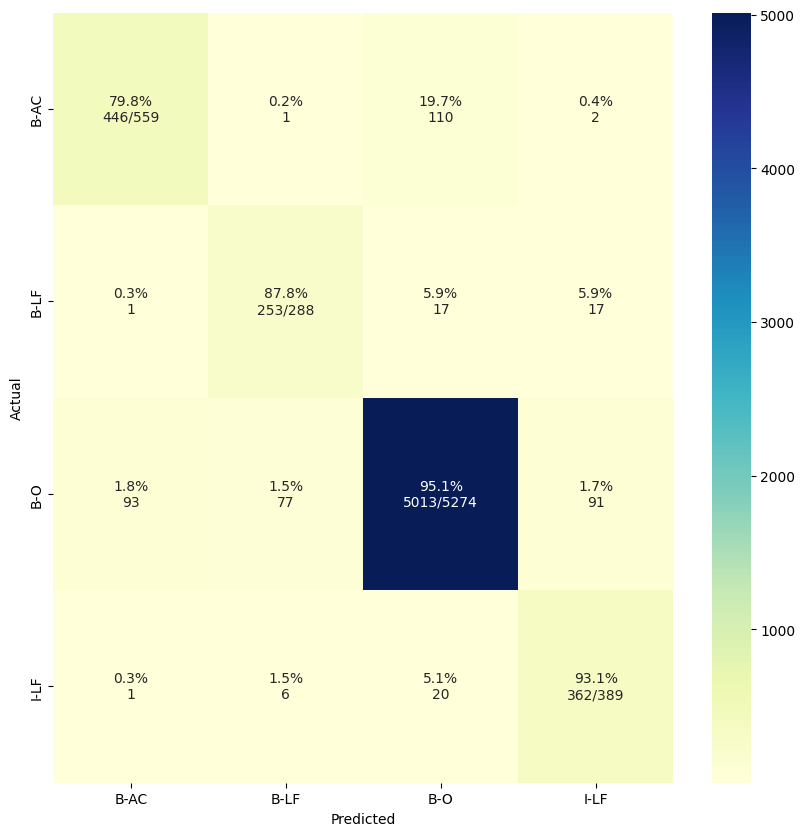

In [6]:
rob1_true_labels_flat = [item for sublist in rob1_true_labels for item in sublist]
rob1_true_predictions_flat = [item for sublist in rob1_true_predictions for item in sublist]

results_rob1 = classification_report(rob1_true_labels, rob1_true_predictions, digits=2)
print(results_rob1)

plot_cm(rob1_true_labels_flat, rob1_true_predictions_flat)

#### Results for 3.2

              precision    recall  f1-score   support

          AC       0.83      0.81      0.82       559
          LF       0.72      0.81      0.76       290
           O       0.97      0.96      0.96      5274

   micro avg       0.94      0.94      0.94      6123
   macro avg       0.84      0.86      0.85      6123
weighted avg       0.94      0.94      0.94      6123



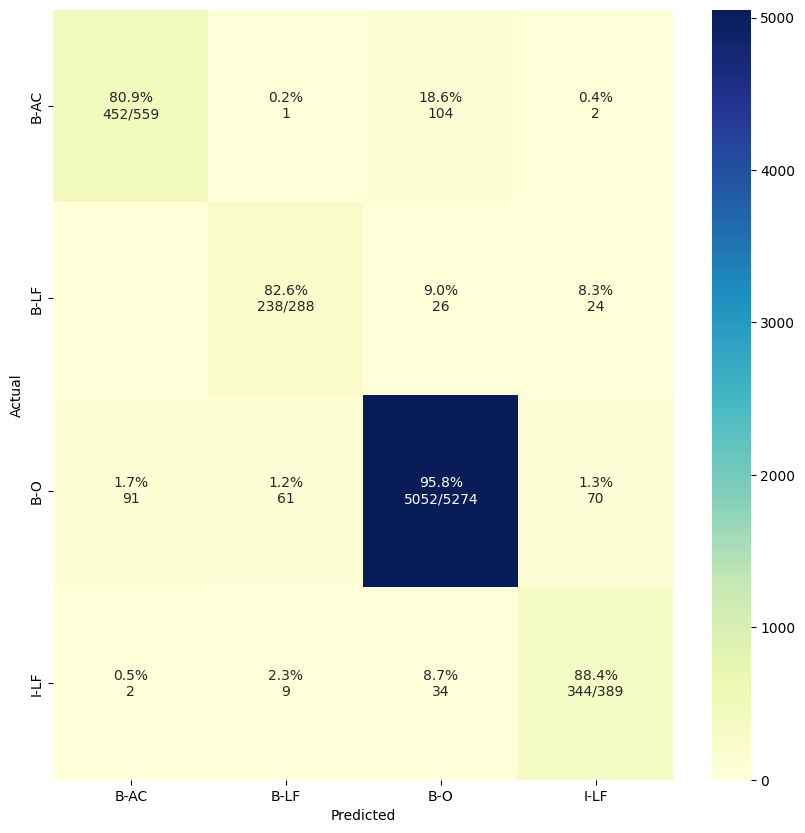

In [8]:
rob2_true_labels_flat = [item for sublist in rob2_true_labels for item in sublist]
rob2_true_predictions_flat = [item for sublist in rob2_true_predictions for item in sublist]

results_rob2 = classification_report(rob2_true_labels, rob2_true_predictions, digits=2)
print(results_rob2)


plot_cm(rob2_true_labels_flat, rob2_true_predictions_flat)


#### Results for 3.3

              precision    recall  f1-score   support

          AC       0.84      0.83      0.84       559
          LF       0.70      0.73      0.71       290
           O       0.97      0.96      0.96      5274

   micro avg       0.94      0.94      0.94      6123
   macro avg       0.84      0.84      0.84      6123
weighted avg       0.94      0.94      0.94      6123



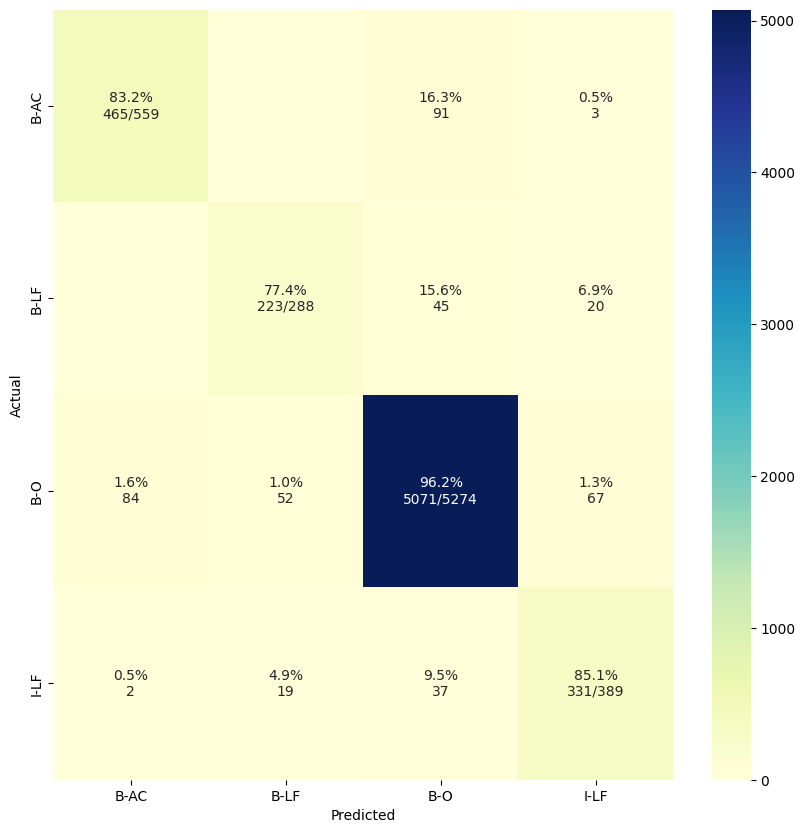

In [12]:
rob3_true_labels_flat = [item for sublist in rob3_true_labels for item in sublist]
rob3_true_predictions_flat = [item for sublist in rob3_true_predictions for item in sublist]

results_rob3 = classification_report(rob3_true_labels, rob3_true_predictions, digits=2)
print(results_rob3)


plot_cm(rob3_true_labels_flat, rob3_true_predictions_flat)

### Experiment 4

#### Results for 4.1

{'AC': {'precision': 0.7309644670050761, 'recall': 0.7897623400365631, 'f1': 0.7592267135325133, 'number': 547}, 'LF': {'precision': 0.5412541254125413, 'recall': 0.543046357615894, 'f1': 0.5421487603305785, 'number': 302}, 'O': {'precision': 0.9620969262681501, 'recall': 0.9453400037057624, 'f1': 0.953644859813084, 'number': 5397}, 'overall_precision': 0.9194771663708246, 'overall_recall': 0.9122638488632725, 'overall_f1': 0.9158563047496583, 'overall_accuracy': 0.9123440084197865}
              precision    recall  f1-score   support

          AC       0.73      0.79      0.76       547
          LF       0.54      0.54      0.54       302
           O       0.96      0.95      0.95      5397

   micro avg       0.92      0.91      0.92      6246
   macro avg       0.74      0.76      0.75      6246
weighted avg       0.92      0.91      0.92      6246



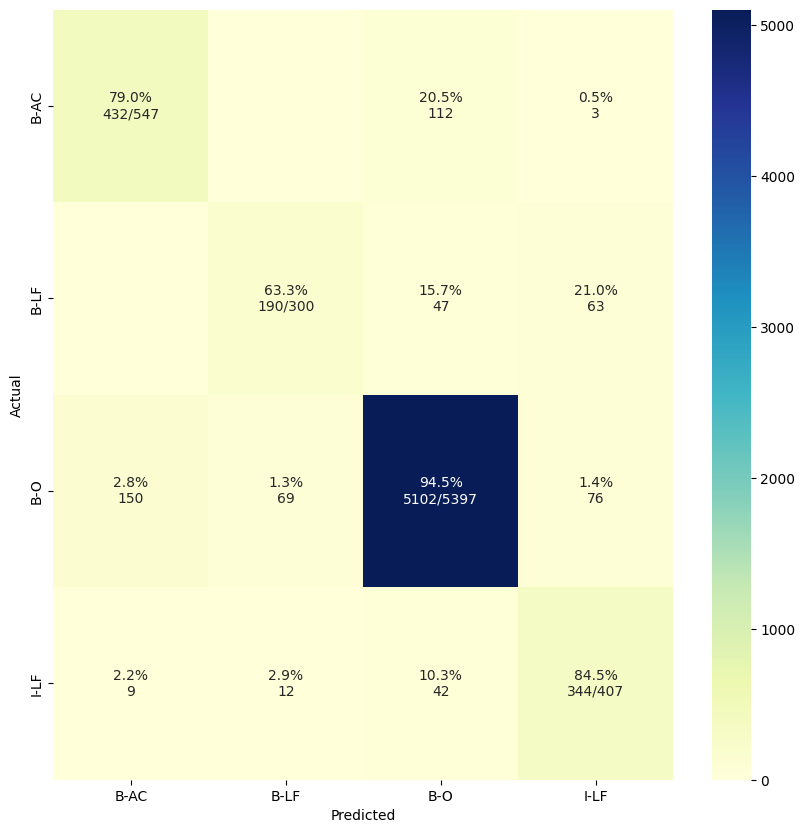

In [23]:
plot_cm(Distil_CW_true_labels_flat, Distil_CW_true_predictions_flat)

results_CW = metric.compute(predictions=Distil_CW_true_predictions, references=Distil_CW_true_labels)
print(results_CW)

print(classification_report(Distil_CW_true_labels, Distil_CW_true_predictions, digits=2))

#### Results for 4.2

{'AC': {'precision': 0.8647402439354193, 'recall': 0.9113983582259719, 'f1': 0.887456460498744, 'number': 140336}, 'LF': {'precision': 0.7966452584280236, 'recall': 0.8763376162933634, 'f1': 0.8345933689470537, 'number': 77283}, 'O': {'precision': 0.9776781700265736, 'recall': 0.9551026833158527, 'f1': 0.9662585822876804, 'number': 1149846}, 'overall_precision': 0.9540132589401253, 'overall_recall': 0.9461660810331526, 'overall_f1': 0.9500734667262918, 'overall_accuracy': 0.9458014182305234}
              precision    recall  f1-score   support

          AC       0.86      0.91      0.89    140336
          LF       0.80      0.88      0.83     77283
           O       0.98      0.96      0.97   1149846

   micro avg       0.95      0.95      0.95   1367465
   macro avg       0.88      0.91      0.90   1367465
weighted avg       0.96      0.95      0.95   1367465



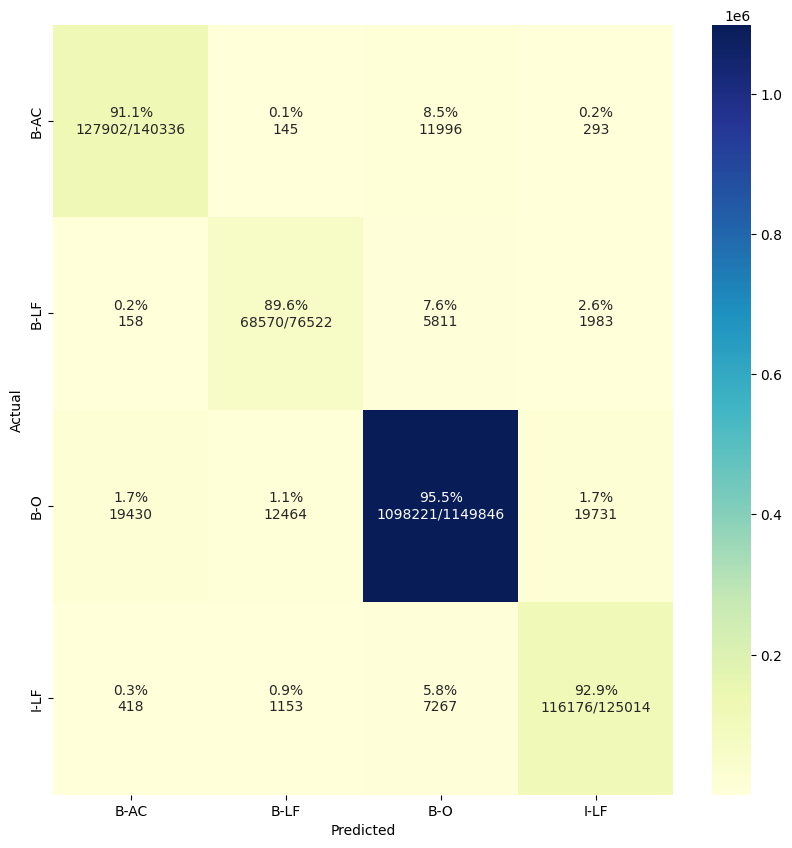

In [33]:
plot_cm(Distil_F_true_labels_flat, Distil_F_true_predictions_flat)

results_F = metric.compute(predictions=Distil_F_true_predictions, references=Distil_F_true_labels)
print(results_F)
from seqeval.metrics import classification_report

print(classification_report(Distil_F_true_labels, Distil_F_true_predictions, digits=2))

#### Results for 4.3

{'AC': {'precision': 0.8660661112898478, 'recall': 0.9070190908374017, 'f1': 0.8860696552255425, 'number': 139491}, 'LF': {'precision': 0.8020442489325915, 'recall': 0.8795970228190344, 'f1': 0.8390323731712418, 'number': 77523}, 'O': {'precision': 0.9780140886933253, 'recall': 0.9565943901208156, 'f1': 0.967185661541843, 'number': 1159205}, 'overall_precision': 0.9550714582434321, 'overall_recall': 0.947232235567159, 'overall_f1': 0.9511356945389914, 'overall_accuracy': 0.946961507355002}
              precision    recall  f1-score   support

          AC       0.87      0.91      0.89    139491
          LF       0.80      0.88      0.84     77523
           O       0.98      0.96      0.97   1159205

   micro avg       0.96      0.95      0.95   1376219
   macro avg       0.88      0.91      0.90   1376219
weighted avg       0.96      0.95      0.95   1376219



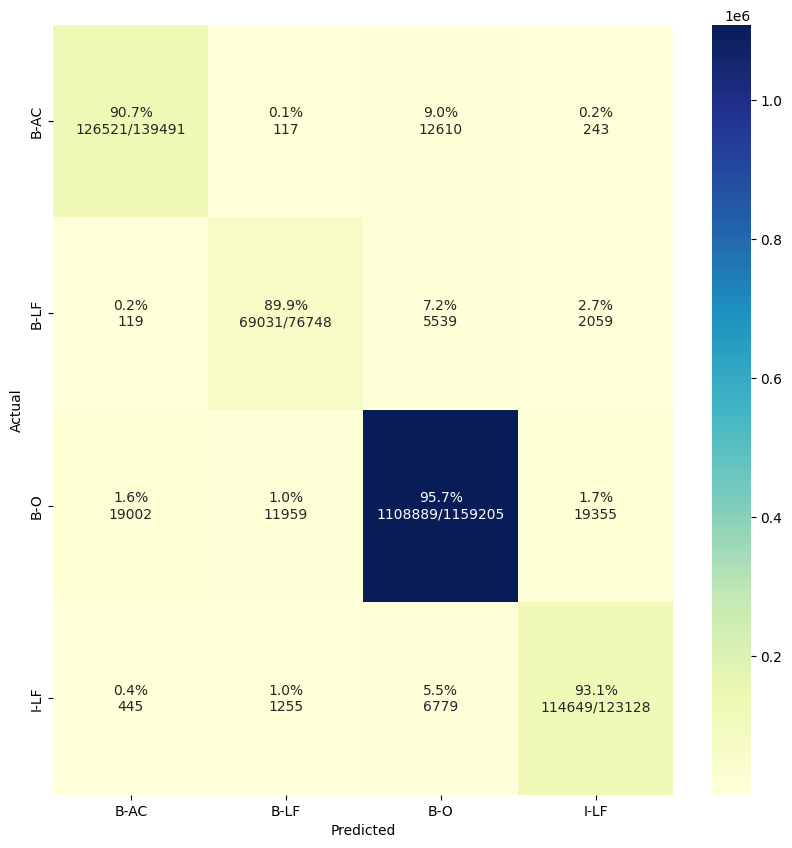

In [35]:
plot_cm(Distil_Unf_true_labels_flat, Distil_Unf_true_predictions_flat)

results_Unf = metric.compute(predictions=Distil_Unf_true_predictions, references=Distil_Unf_true_labels)
print(results_Unf)

print(classification_report(Distil_Unf_true_labels, Distil_Unf_true_predictions, digits=2))